In [4]:
import numpy as np
import tifffile as tf
import zarr
from scipy.stats import pearsonr
from tqdm import tqdm
import pandas as pd
import plotly.express as px
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from random import shuffle
import matplotlib.pyplot as plt
import numpy as np
import re
import json


In [5]:
file_path = '/Volumes/Simon/P37_S33_A24_C59kX_E15_20220107_180446_881530-zlib.ome.tiff'
image_size = 1024

In [6]:
channel_data = tf.TiffFile(file_path, is_ome=False)
channel_data

<tifffile.TiffFile 'P37_S33_A24_C59k…0-zlib.ome.tiff'>

In [7]:
channels = zarr.open(channel_data.series[0].aszarr())

In [8]:
def get_offsets(tiff_filepath):
    with tf.TiffFile(tiff_filepath) as tif:
        offsets = [page.offset for page in tif.pages]
    return offsets


def generate_tiff_offsets(input_file):
    # Get list of offsets.
    offsets = get_offsets(str(input_file))

    # Get output path for OME.TIFF.
    # Set output filename for JSON file and dump to disk.
    output_path = re.sub(r'((\.ome)?\.tiff?)', '.offsets.json', str(input_file))
    with open(output_path, 'w+') as f:
        f.write(json.dumps(offsets))


In [9]:

valid_starting_pixels = []
for zoom_level in tqdm(range(len(channels)), desc='Zoom Levels'):
    width, height = channels[zoom_level].shape[1], channels[zoom_level].shape[2]
    crop_offset = 2**(len(channels)-zoom_level)    
    valid_starting_pixels.extend(
        [(zoom_level, x, y) for x in range(0,width - image_size - 1,crop_offset) for y in range(0,height - image_size - 1,crop_offset)]
    )


Zoom Levels: 100%|██████████| 8/8 [00:00<00:00, 280.18it/s]


In [10]:
len(valid_starting_pixels)

355456

In [11]:
# # Calculate perason correlation coefficient for each pixel
# from scipy.stats import pearsonr
# correlation_coefficients = []
# for i in tqdm(range(channels[4].shape[0])):
#     this_row = []
#     for j in range(channels[4].shape[0]):
#         this_row.append(pearsonr(channels[4][i,:,:].flatten(), channels[4][j,:,:].flatten())[0])
#     correlation_coefficients.append(this_row)


In [12]:
meaned = np.array(channels[5]).mean(axis=0)


In [13]:
# fig = px.histogram(meaned.flatten())
# fig.show()

In [14]:
dna = np.array(channels[5][0])
dna_log = np.log(dna[dna > 0])
gmm = GaussianMixture(3, max_iter=1000, tol=1e-6)
gmm.fit(dna_log.reshape((-1, 1)))
means = gmm.means_[:, 0]
i0, i1, i2 = np.argsort(means)
mean1, mean2 = means[[i1, i2]]
std1, std2 = gmm.covariances_[[i1, i2], 0, 0] ** 0.5

x = np.linspace(mean1, mean2, 50)
y1 = norm(mean1, std1).pdf(x) * gmm.weights_[i1]
y2 = norm(mean2, std2).pdf(x) * gmm.weights_[i2]

lmax = mean2 + 2 * std2
lmin = x[np.argmin(np.abs(y1 - y2))]
if lmin >= mean2:
    lmin = mean2 - 2 * std2
vmin = max(np.exp(lmin), dna.min(), 0)
vmax = min(np.exp(lmax), dna.max())
(vmin, vmax)

(729.2888867137801, 6387.6872012897775)

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


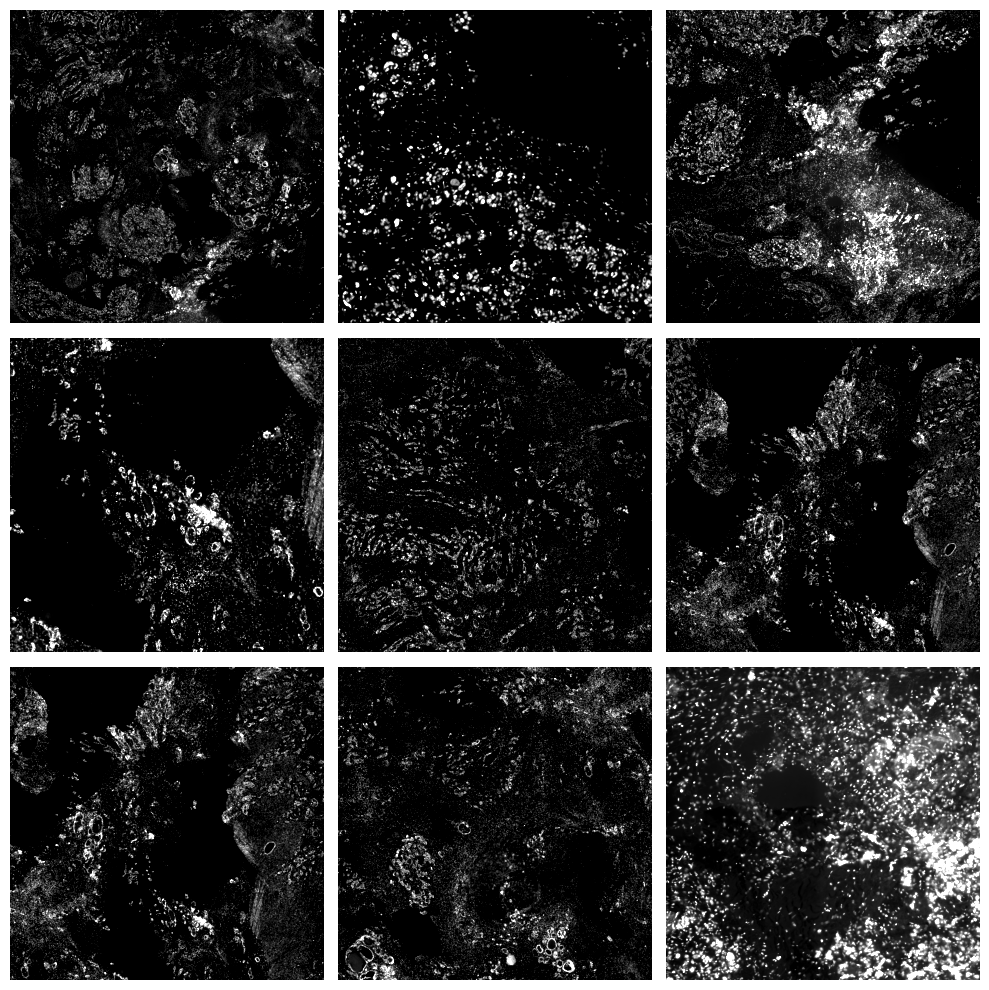

In [16]:
# Randomly select 1000 intigers in range 0,len(valid_starting_pixels)
indices = np.random.choice(len(valid_starting_pixels), 100, replace=False)
test_arr = []
num_rows = 3
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
ii = 0;
for i in tqdm(indices):
    ind = valid_starting_pixels[i]
    vals = np.array(channels[ind[0]][0,ind[1]:ind[1]+image_size,ind[2]:ind[2]+image_size])
    average_value = np.mean(vals)
    # Check if avg is in range (vmin,vmax)
    in_range = 0
    if vmin < average_value < vmax:
        in_range= 1;
        if ii < 9:
            axs.flat[ii].imshow(vals, cmap='gray', vmin=vmin, vmax=vmax)
            axs.flat[ii].axis('off')
        channels_inds = np.random.choice(channels[ind[0]].shape[0], 8, replace=False)
        dat = np.array(channels[ind[0]][channels_inds,ind[1]:ind[1]+image_size,ind[2]:ind[2]+image_size])
        filename = f'/Volumes/Simon/crops/{ind[0]}_{ind[1]}_{ind[2]}.ome.tiff'

        tf.imwrite(
            filename,
            dat,
            bigtiff=True,
            metadata={
                'axes': 'CYX',
                'SignificantBits': 10
            },
        )
        generate_tiff_offsets(filename)
        ii += 1
        
    test_arr.append([average_value,in_range])
plt.tight_layout()
plt.show()


In [ ]:
# pick 8 random integers in range 0,channels[ind[0]].shape[0] without duplicates
channels_inds = np.random.choice(channels[ind[0]].shape[0], 8, replace=False)
np.array(channels[ind[0]][channels_inds,ind[1]:ind[1]+image_size,ind[2]:ind[2]+image_size]).shape

(8, 1024, 1024)